# Start with Kaggle comps: Future sales

The aim of this notebook is to predict monthly sales of a series of products from the C1 company. This includes working with time-series and managing considerably large datasets, and we will need some advanced techniques to deal with them.

Main workflow of the algorithm:
1. Step 1. Load data
2. Step 2. Data exploration (EDA)
3. Step 3. Missings cleaning
4. Step 4. Feature engineering
5. Step 5. Mean encoding and generation of lag
6. Step 6. Data preparation and prediction (LGBoost) 

Let's start by importing the libraries:

In [1]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance

import time
import datetime
import re
from itertools import product
from math import isnan
import scipy.stats as stats

import gc
import pickle

import os
print(os.listdir("../input"))

# DISCLAIMER: Some procedures and ideas (in particular feature couples to extract lag and duplicated russian shop_names) in this kernel have been influenced by the following two kernels:
#https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
#https://www.kaggle.com/dlarionov/feature-engineering-xgboost

['competitive-data-science-predict-future-sales']


## Step1. Load data

This step consists on several procedures, not just data loading as usually:
* Read all data files provided by Kaggle competition
* Display load data
* Join train/test data and fill some values as the month of the test data
* Define a function to downgrade data types (to deal with massive arrays) for future use
* Fill some missings with 0s 
* Generate support flag features (in_test, is_new_item)

In [2]:
# Load input files
sales_train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv", parse_dates=['date'], infer_datetime_format=False, dayfirst=True)
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

# Take a brief look on the content
print("Sales_train")
display(sales_train.head(10))
print("Test")
display(test.head(10))
print("Item_categories")
display(item_categories.head(10))
print("Items")
display(items.head(10))
print("Shops")
display(shops.head(1))

# Auxiliar function to reduce data storage
def downcast_dtypes(df):
    # Columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    return df

# Prepare the test set to merge it with sales_train
test['date_block_num'] = 34
test['date'] = datetime.datetime(2015, 11, 1, 0, 0, 0)

# Join train and test sets. Fill date_block_num = 34 for test rows 
all_data = pd.concat([sales_train, test], axis = 0, sort=False)
all_data['date_block_num'].fillna(34, inplace=True)

# Create flag (in_test) for month=34
all_data['in_test'] = 0
all_data.loc[all_data.date_block_num == 34, 'in_test'] = 1

# Create a flag (is_new_item) for elements in test not in sales_train
new_items = (set(test['item_id'].unique()) - set(sales_train['item_id'].unique()))
all_data.loc[all_data['item_id'].isin(new_items), 'is_new_item'] = 1

# Fill missings with 0
all_data.fillna(0, inplace=True)
all_data = downcast_dtypes(all_data)
all_data = all_data.reset_index()
display(all_data.head(10))

print("Train set size: ", len(sales_train))
print("Test set size: ", len(test))
print("Item categories set size: ", len(item_categories))
print("Items set size: ", len(items))
print("Shops set size: ", len(shops))
print("All data size: ", len(all_data))
print("Duplicates in train dataset: ", len(sales_train[sales_train.duplicated()]))

Sales_train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


Test


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


Item_categories


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


Items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


Shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,in_test,is_new_item
0,0,2013-01-02,0,59,22154,999.0,1.0,0.0,0,0.0
1,1,2013-01-03,0,25,2552,899.0,1.0,0.0,0,0.0
2,2,2013-01-05,0,25,2552,899.0,-1.0,0.0,0,0.0
3,3,2013-01-06,0,25,2554,1709.0,1.0,0.0,0,0.0
4,4,2013-01-15,0,25,2555,1099.0,1.0,0.0,0,0.0
5,5,2013-01-10,0,25,2564,349.0,1.0,0.0,0,0.0
6,6,2013-01-02,0,25,2565,549.0,1.0,0.0,0,0.0
7,7,2013-01-04,0,25,2572,239.0,1.0,0.0,0,0.0
8,8,2013-01-11,0,25,2572,299.0,1.0,0.0,0,0.0
9,9,2013-01-03,0,25,2573,299.0,3.0,0.0,0,0.0


Train set size:  2935849
Test set size:  214200
Item categories set size:  84
Items set size:  22170
Shops set size:  60
All data size:  3150049
Duplicates in train dataset:  6


## Step 2. Data exploration (EDA)

In the previous step, we had the opportunity to see how data is structured and which types of data are we dealing with. However, we haven't analysed the existance of outliers, abnormal values (either extremely high or low), duplicate categorical values, etc. That's what we will study in the following code blocks. 

A brief summary of our EDA:
* Analyze extreme values in item_price and item_cnt_day
* Deal with the outliers (extremely large values and negative counts)
* Find and deal with duplicates in shop_name
* Fix negative item_prices
* Create an enriched dataset for further exploration (optional but recommended). Includes some feature engineering
* Analyze sells by price categories 
* Analyze monthly sales
* Create a correlation matrix

,index,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,in_test,is_new_item
count,3.150049e+06,3.150049e+06,3.150049e+06,3.150049e+06,3150049.0,3150049.0,3150049.0,3.150049e+06,3.150049e+06
mean,1.375389e+06,1.589114e+01,3.290933e+01,1.025313e+04,NaN,NaN,NaN,6.799894e-02,4.840851e-03
std,8.871567e+05,1.032864e+01,1.632479e+01,6.322838e+03,NaN,NaN,NaN,2.517441e-01,6.939697e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.0,-22.0,0.0,0.000000e+00,0.000000e+00
25%,5.733120e+05,7.000000e+00,2.200000e+01,4.510000e+03,199.0,1.0,0.0,0.000000e+00,0.000000e+00
50%,1.360824e+06,1.500000e+01,3.100000e+01,9.461000e+03,399.0,1.0,0.0,0.000000e+00,0.000000e+00
75%,2.148336e+06,2.400000e+01,4.700000e+01,1.572700e+04,899.0,1.0,0.0,0.000000e+00,0.000000e+00
max,2.935848e+06,3.400000e+01,5.900000e+01,2.216900e+04,inf,2168.0,inf,1.000000e+00,1.000000e+00


Item_price outlier: 
index                         1163158
date              2013-12-13 00:00:00
date_block_num                     11
shop_id                            12
item_id                          6066
item_price                        inf
item_cnt_day                        1
ID                                  0
in_test                             0
is_new_item                         0
Name: 1163158, dtype: object

Item_cnt_day maximum: 
index                         2909818
date              2015-10-28 00:00:00
date_block_num                     33
shop_id                            12
item_id                         11373
item_price                   0.908691
item_cnt_day                     2168
ID                                  0
in_test                             0
is_new_item                         0
Name: 2909818, dtype: object
['!Якутск Орджоникидзе, 56 фран' '!Якутск ТЦ "Центральный" фран'
 'Адыгея ТЦ "Мега"' 'Балашиха ТРК "Октябрь-Киномир"'
 'Волжский ТЦ "Волг

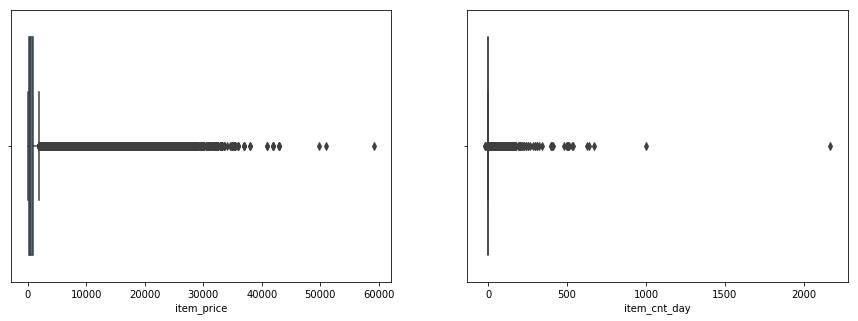

In [3]:
# Describe merged data to look for inusual values
display(all_data.describe())
print("Item_price outlier: ")
print(all_data.loc[all_data['item_price'].idxmax()])
print("\nItem_cnt_day maximum: ")
print(all_data.loc[all_data['item_cnt_day'].idxmax()])

f1, axes = plt.subplots(1, 2, figsize=(15,5))
f1.subplots_adjust(hspace=0.4, wspace=0.2)
sns.boxplot(x=all_data['item_price'], ax=axes[0])
sns.boxplot(x=all_data['item_cnt_day'], ax=axes[1])

print(shops['shop_name'].unique())

Conclusions by now:
1. There are negative prices and counts (errors, returns?)
2. Item_id = 6066 has an abnormal large price (item_price = 307980), and is only sold one time
3. 2 items have very large item_cnt_day when compared with the other products
4. Shop_name contains the shops' city names (Москва, Moscow). An additional feature can be obtained
5. Якутск city is expressed as Якутск and !Якутск. This could be fixed
6. Shop_id = 0 & 1 are the same than 57 & 58 but for фран (Google translator => fran, maybe franchise). Shop_id = 10 & 11 are the same

Let's tackle these outliers, duplicates and negative numbers.

In [4]:
# Drop outliers and negative counts (see graphs below)
all_data = all_data.drop(all_data[all_data['item_price']>100000].index)
all_data = all_data.drop(all_data[all_data['item_cnt_day']>1100].index)
sales_train = sales_train.drop(sales_train[sales_train['item_price']>100000].index)
sales_train = sales_train.drop(sales_train[sales_train['item_cnt_day']>1100].index)

# There are shops with same address and almost same name in russian. 
# Unify duplicated shops (see https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
all_data.loc[all_data['shop_id'] == 11,'shop_id'] = 10
all_data.loc[all_data['shop_id'] == 57,'shop_id'] = 0
all_data.loc[all_data['shop_id'] == 58,'shop_id'] = 1
sales_train.loc[sales_train['shop_id'] == 11,'shop_id'] = 10
sales_train.loc[sales_train['shop_id'] == 57,'shop_id'] = 0
sales_train.loc[sales_train['shop_id'] == 58,'shop_id'] = 1
test.loc[test['shop_id'] == 11,'shop_id'] = 10
test.loc[test['shop_id'] == 57,'shop_id'] = 0
test.loc[test['shop_id'] == 58,'shop_id'] = 1

# Instead of deleting negative price items, replace them with the median value for the impacted group:
all_data.loc[all_data['item_price'] < 0, 'item_price'] = all_data[(all_data['shop_id'] == 32) & 
                                                                  (all_data['item_id'] == 2973) & 
                                                                  (all_data['date_block_num'] == 4) & 
                                                                  (all_data['item_price'] > 0)].item_price.median()

print("Raw data length: ",len(sales_train), ", post-outliers length: ", len(all_data))

Raw data length:  2935847 , post-outliers length:  3150047


Now, an enriched matrix with additional features will be created just for data exploration purposes. This may proof useful later on to think about how to structure our data and have a general view of our datasets.

**Disclaimer**: This is completely optional and techniques used to enrich data should be considered as feature engineering. However, while developping this kernel I found it useful to figure out which way to deal with time-series data.

In [5]:
ts = time.time()

# Enrich data with additional features and aggregates for data exploration purposes
def enrich_data(all_data, items, shops, item_categories):
    
    # Aggregate at month level. Calculate item_cnt_month and item_price (median)
    count_data = all_data.groupby(['shop_id', 'item_id', 'date_block_num', 'in_test', 'is_new_item'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
    price_data = all_data.groupby(['shop_id', 'item_id', 'date_block_num', 'in_test', 'is_new_item'])['item_price'].median().rename('item_price_median').reset_index()
    all_data = pd.merge(count_data, price_data, on=['shop_id', 'item_id', 'in_test', 'date_block_num', 'is_new_item'], how='left')

    # Extract day, month, year
    #all_data['day'] = all_data['date'].dt.day
    #all_data['month'] = all_data['date'].dt.month
    #all_data['year'] = all_data['date'].dt.year

    # Add item, shop and item_category details 
    all_data = all_data.join(items, on='item_id', rsuffix='_item')
    all_data = all_data.join(shops, on='shop_id', rsuffix='_shop')
    all_data = all_data.join(item_categories, on='item_category_id', rsuffix='_item_category')
    all_data = all_data.drop(columns=['item_id_item', 'shop_id_shop', 'item_category_id_item_category', 'item_name'])
    
    # Extract main category and subcategory from category name
    categories_split = all_data['item_category_name'].str.split('-')
    all_data['main_category'] = categories_split.map(lambda row: row[0].strip())
    all_data['secondary_category'] = categories_split.map(lambda row: row[1].strip() if (len(row)>1) else 'N/A')
    
     # Extract cities information from shop_name. Replace !Якутск by Якутск since it's the same city
    all_data['city'] = all_data['shop_name'].str.split(' ').map(lambda row: row[0])
    all_data.loc[all_data.city == '!Якутск', 'city'] = 'Якутск'

    # Encode cities and categories
    encoder = sklearn.preprocessing.LabelEncoder()
    all_data['city_label'] = encoder.fit_transform(all_data['city'])
    all_data['main_category_label'] = encoder.fit_transform(all_data['main_category'])
    all_data['secondary_category_label'] = encoder.fit_transform(all_data['secondary_category'])
    all_data = all_data.drop(['city', 'shop_name', 'item_category_name', 'main_category', 'secondary_category'], axis = 1)

    # Create price categories (0-5, 5-10, 10,20, 20,30, 30-50, 50-100, >100)
    def price_category(row):
        if row.item_price_median<5.:
            val = 1
        elif row.item_price_median<10.:
            val = 2
        elif row.item_price_median<100.:
            val = 3
        elif row.item_price_median<200.:
            val = 4
        elif row.item_price_median<300.:
            val = 5
        elif row.item_price_median<500.:
            val = 6
        elif row.item_price_median<1000.:
            val = 7
        elif row.item_price_median>1000.:
            val = 8
        else:
            val = 0
        return val
    
    all_data['price_cat'] = all_data.apply(price_category, axis=1)
    
    # Downgrade numeric data types
    all_data = downcast_dtypes(all_data)
    
    # Performance test dropping month_cnt
    #all_data.drop('item_cnt_month', axis=1, inplace=True)
    
    return all_data

all_data2 = enrich_data(all_data, items, shops, item_categories)
items_prices = all_data2[['item_id', 'shop_id', 'date_block_num', 'item_price_median', 'price_cat']]

time.time() - ts

all_data2.head()

,shop_id,item_id,date_block_num,in_test,is_new_item,item_cnt_month,item_price_median,item_category_id,city_label,main_category_label,secondary_category_label,price_cat
0,0,30,1,0,0.0,31.0,265.0,40,29,11,4,5
1,0,30,2,0,0.0,24.0,399.0,40,29,11,4,6
2,0,30,3,0,0.0,3.0,399.0,40,29,11,4,6
3,0,30,4,0,0.0,1.0,399.0,40,29,11,4,6
4,0,30,6,0,0.0,1.0,399.0,40,29,11,4,6


Alright, now we have an advanced view of the kind of data we are dealing with. This will help us to define how to wotk with time-series in the following steps. But first, let's finish our exploratory analysis by:
* Study monthly sales by month 
* Study monthly sales by price category
* Look at the correlation matrix of our enriched data.

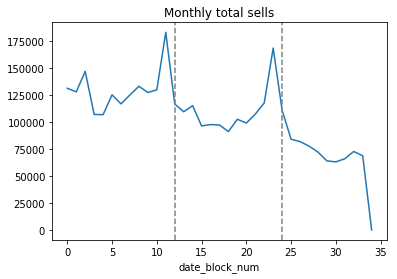

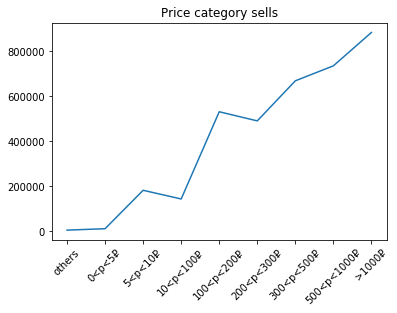

In [6]:
# Analyze monthly sells for all shops
all_data2['item_cnt_month'] = all_data2['item_cnt_month'].astype(np.float64)
count_monthly_sales = all_data2.groupby('date_block_num').item_cnt_month.sum(axis=0)

f = plt.figure()
ax = f.add_subplot(111)
plt.plot(count_monthly_sales)
plt.axvline(x=12,color='grey',linestyle='--')  # Vertical grey line for December month
plt.axvline(x=24,color='grey',linestyle='--')
plt.xlabel("date_block_num")
plt.title('Monthly total sells')
plt.show()

# Analyze monthly sells for each price category
count_price_cat_sales = all_data2.groupby('price_cat').item_cnt_month.sum(axis=0)

f = plt.figure()
ax = f.add_subplot(111)
plt.plot(count_price_cat_sales)
plt.xticks([0,1,2,3,4,5,6,7,8],['others', '0<p<5₽','5<p<10₽','10<p<100₽','100<p<200₽','200<p<300₽','300<p<500₽','500<p<1000₽','>1000₽'], rotation='45')
plt.title('Price category sells')
plt.show()

Looks like C1 company has a decreasing tendency on sales. There are some reasons for this behavior (depreciation of the ruble), but we don't need to tackle this explicitly for our prediction purposes since the algorithm will detect the tendency automatically from data.
Additionally, we see there's an increasing sales count on items with higher prices, but this could be due to our bin size. Just take it into account.

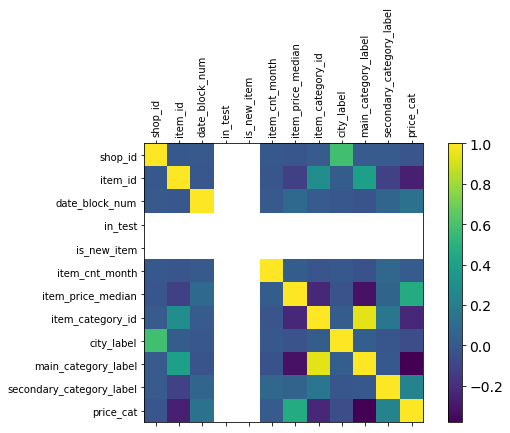

In [7]:
# Correlation matrix for monthly sales
all_data2 = all_data2[all_data2['date_block_num']<34]
#all_data2 = all_data2.drop(columns=['in_test', 'is_new_item'], inplace=True)

# Correlation matrix
f = plt.figure(figsize=(9, 5))
plt.matshow(all_data2.corr(), fignum=f.number)
plt.xticks(range(all_data2.shape[1]),all_data2.columns, fontsize=10, rotation=90)
plt.yticks(range(all_data2.shape[1]), all_data2.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Not surprising correlations, but a good look-up result in case we find something interesting later on.

# Step 3. Missings cleaning

Since we filled missing values with 0s, we expect little or no missings in this section. However, it's always a good practice to check out before feature engineering and detection.

In [8]:
# Missings count. There are no missings (remind that we filled all missings on the beginning of this kernel with  0s)
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
index           0
date            0
date_block_num  0
shop_id         0
item_id         0
item_price      0
item_cnt_day    0
ID              0
in_test         0
is_new_item     0


# Step 4. Feature engineering

Steps 4 and 5 are those in which we will need to be more incisive. Since data is strongly dependent on time, it's important to define how to work with it. 

Here we have two options:
* Do we create a row for each item/shop pair and then create a column for each month? 
* Or it could be better to generate one different row for each item/shop/date_block_num sale

You can try the first option to obtain some decent results (you can see the results here https://www.kaggle.com/saga21/start-with-kaggle-comps-future-sales-v0), but we can make a step further and decide to structure data by item/shop/date_month. With this, we will have a row for each monthly sale, which will help the algorithm to predict future data (and not just predict an additional column for the new month).

What we will do:
* Generate all combinations of existent item/shop/date_block_num (cartesian product) from the training set
* Revenue. New feature from item_price * item_cnt_day
* Item_cnt_month. New feature from grouping item/shops by month and summing the item_cnt_day
* Join test data
* Join item, shop and item category details (see additional files provided by the competition)
* Month. Numeric month value from 1 to 12
* Days. Number of days in each month (no leap years)
* Main_category. From item categories, extract the principal type
* Secondary_category. From item categories, extract the secondary type
* City. Extract the city from shop_name
* Shop_type. Extract the type from shop_name
* Encode categorical columns: main_category, secondary_category, city and shop_type

In [9]:
ts = time.time()

# Extend all_data for all item/shop pairs. 
def add_all_pairs(sales_train, test, items, shops, item_categories, items_prices):
    
    tmp = []
    for month in range(34):
        sales = sales_train[sales_train.date_block_num==month]
        tmp.append(np.array(list(product([month], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

    tmp = pd.DataFrame(np.vstack(tmp), columns=['date_block_num','shop_id','item_id'])
    tmp['date_block_num'] = tmp['date_block_num'].astype(np.int8)
    tmp['shop_id'] = tmp['shop_id'].astype(np.int8)
    tmp['item_id'] = tmp['item_id'].astype(np.int16)
    tmp.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
    
    sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']
    group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
    group.columns = ['item_cnt_month']
    group.reset_index(inplace=True)
    tmp = pd.merge(tmp, group, on=['date_block_num','shop_id','item_id'], how='left')
    tmp['item_cnt_month'] = (tmp['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))
    tmp = pd.concat([tmp, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
    
    #price_data = tmp.groupby(['shop_id', 'item_id', 'date_block_num', 'in_test', 'is_new_item'])['item_price'].median().rename('item_price_median').reset_index()
    #tmp = tmp.join(price_data, on=[[]])
    
    # Add item, shop and item_category details 
    tmp = tmp.join(items, on='item_id', rsuffix='_item')
    tmp = tmp.join(shops, on='shop_id', rsuffix='_shop')
    tmp = tmp.join(item_categories, on='item_category_id', rsuffix='_item_category')
    tmp = pd.merge(tmp, items_prices, on=['date_block_num','shop_id','item_id'], how='left')
    tmp = tmp.drop(columns=['item_id_item', 'shop_id_shop', 'item_category_id_item_category', 'item_name'])
    
    # Extract month, year & nºdays in each month
    tmp['month'] = tmp['date_block_num']%12
    tmp['days'] = tmp['month'].map(pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]))
    
    # Extract main category and subcategory from category name
    categories_split = tmp['item_category_name'].str.split('-')
    tmp['main_category'] = categories_split.map(lambda row: row[0].strip())
    tmp['secondary_category'] = categories_split.map(lambda row: row[1].strip() if (len(row)>1) else 'N/A')
    
    # Extract cities information from shop_name. Replace !Якутск by Якутск since it's the same city.
    tmp['city'] = tmp['shop_name'].str.split(' ').map(lambda row: row[0])
    tmp.loc[tmp.city == '!Якутск', 'city'] = 'Якутск'
    tmp['shop_type'] = tmp['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x 
                                              else 'трц' if 'трц' in x 
                                              else 'трк' if 'трк' in x 
                                              else 'тц' if 'тц' in x 
                                              else 'тк' if 'тк' in x 
                                              else 'NO_DATA')

    # Encode cities and categories
    encoder = sklearn.preprocessing.LabelEncoder()
    tmp['city_label'] = encoder.fit_transform(tmp['city'])
    tmp['shop_type_label'] = encoder.fit_transform(tmp['shop_type'])
    tmp['main_category_label'] = encoder.fit_transform(tmp['main_category'])
    tmp['secondary_category_label'] = encoder.fit_transform(tmp['secondary_category'])
    tmp = tmp.drop(['ID', 'city', 'date', 'shop_name', 'item_category_name', 'main_category', 'secondary_category'], axis = 1)
    
    # Downgrade numeric data types
    tmp = downcast_dtypes(tmp)

    tmp.fillna(0, inplace=True)
    return tmp
    
all_pairs = add_all_pairs(sales_train, test, items, shops, item_categories, items_prices)

time.time() - ts

155.73356246948242

Fine, so we have extracted some nice additional features and now our sales have one row for each item/shop/date_block_num. It looks promising. 

# Step 5. Mean encoding

LGB algorithm read rows to extract information from them and predict the target value. We need to provide the algorithm with the historical information for each item, and this is obtained through lags. Lags are essentially columns with information from the past. For example, a lag of 1 month from item_cnt_month would inform about the last month sales for this item. 

What we will add:
* **Downgrade** (again) data to deal with large arrays
* **Support functions**. Create some support functions for lag generation; calculate_lag, prepare_lag_columns and prepare_lag_columns_price. This allows to calculate automatic lags for several columns in a readable code-friendly style. As a rule of thumb: if you need to calculate the same non-trivial computation more than once, creater a function instead
* **Compute lags**. Lags of monthly sales grouped by several column combinations (how many past sales by shop and category, or by secondary category, etc)
* **Price_trend**. Track item_prices changes to account for price fluctuations (discounts)
* **Drop columns**. Some features were generated in order to compute another one. Drop those that are not useful any more or may introduce data leaking (for example, item_price is strongly correlated to sales, since items that were never sell have no price informed).

In [10]:
ts = time.time()

# First downgrade some columns (still more) to fasten the mean encoding
all_pairs['date_block_num'] = all_pairs['date_block_num'].astype(np.int8)
all_pairs['city_label'] = all_pairs['city_label'].astype(np.int8)
all_pairs['item_cnt_month'] = all_pairs['item_cnt_month'].astype(np.int8)
all_pairs['item_category_id'] = all_pairs['item_category_id'].astype(np.int8)
all_pairs['main_category_label'] = all_pairs['main_category_label'].astype(np.int8)
all_pairs['secondary_category_label'] = all_pairs['secondary_category_label'].astype(np.int8)

# Function to calculate lag over different columns. Lag gives information about a variable from different past times
def calculate_lag(df, lag, column):
    ancilla = df[['date_block_num','shop_id','item_id',column]]
    for l in lag:
        shift_ancilla = ancilla.copy()
        shift_ancilla.columns = ['date_block_num','shop_id','item_id', column+'_lag_'+str(l)]
        shift_ancilla['date_block_num'] += l
        df = pd.merge(df, shift_ancilla, on=['date_block_num','shop_id','item_id'], how='left')
    return df

# Function to specify lag columns,compute item_cnt aggregate (mean) and call calculate_lag
def prepare_lag_columns(df, lag, column_list, name):
    ancilla = df.groupby(column_list).agg({'item_cnt_month':['mean']})
    ancilla.columns = [name]
    ancilla.reset_index(inplace=True)
    df = pd.merge(df, ancilla, on=column_list, how='left')
    df[name] = df[name].astype(np.float16)
    df = calculate_lag(df, lag, name)
    df.drop([name], axis=1, inplace=True)
    return df

# Auxiliar function to compute item_price groups (for trends). Lags will be calculated post-preparation
def prepare_lag_columns_price(df, column_list, name):
    ancilla = sales_train.groupby(column_list).agg({'item_price':['mean']})
    ancilla.columns = [name]
    ancilla.reset_index(inplace=True)
    df = pd.merge(df, ancilla, on=column_list, how='left')
    df[name] = df[name].astype(np.float16)
    return df

# Let's compute all lags for sells. Arguments of the function are :(df, lag_list, column_list, name of the column)
all_pairs = calculate_lag(all_pairs, [1,2,3,4,5,6,12], 'item_cnt_month')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'item_id'], 'total_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1,2,3,4,5,6,12], ['date_block_num'], 'item_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1,2,3,4,5,6,12], ['date_block_num', 'shop_id'], 'shop_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','city_label'], 'city_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','item_id','city_label'], 'item_city_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'item_category_id'], 'category_id_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'main_category_label'], 'main_category_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'secondary_category_label'], 'secondary_category_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','shop_id','item_category_id'], 'shop_category_id_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','shop_id','main_category_label'], 'shop_main_category_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','shop_id','secondary_category_label'], 'shop_secondary_category_avg_month_cnt')


# For item_price the procedure is more tricky. Compute both item price and monthly price in order to compute the trend.
all_pairs = prepare_lag_columns_price(all_pairs, ['item_id'], 'item_avg_price')
all_pairs = prepare_lag_columns_price(all_pairs, ['date_block_num','item_id'], 'item_avg_price_month')
all_pairs = calculate_lag(all_pairs, [1,2,3,4,5,6], 'item_avg_price_month')

for lag in [1,2,3,4,5,6]:
    all_pairs['trend_price_lag_'+str(lag)] = (all_pairs['item_avg_price_month_lag_'+str(lag)] - all_pairs['item_avg_price']) / all_pairs['item_avg_price']

def clean_trend_price_lag(row):
    for l in [1,2,3,4,5,6]:
        if row['trend_price_lag_'+str(l)]:
            return row['trend_price_lag_'+str(l)]
    return 0

# For some reason my kernel expodes when using df.apply() for all rows, so I had to segment it
dummy_1, dummy_2, dummy_3, dummy_4 = [], [], [], []      
dummy_1 = pd.DataFrame(dummy_1)
dummy_2 = pd.DataFrame(dummy_2)
dummy_3 = pd.DataFrame(dummy_3)
dummy_4 = pd.DataFrame(dummy_4)
dummy_1 = all_pairs[:3000000].apply(clean_trend_price_lag, axis=1)
dummy_2 = all_pairs[3000000:6000000].apply(clean_trend_price_lag, axis=1)
dummy_3 = all_pairs[6000000:9000000].apply(clean_trend_price_lag, axis=1)
dummy_4 = all_pairs[9000000:].apply(clean_trend_price_lag, axis=1)
all_pairs['trend_price_lag'] = pd.concat([dummy_1, dummy_2, dummy_3, dummy_4])
all_pairs['trend_price_lag'] = all_pairs['trend_price_lag'].astype(np.float16)
all_pairs['trend_price_lag'].fillna(0, inplace=True)

#all_pairs.drop(['item_avg_price','item_avg_price_month'], axis=1, inplace=True)
for i in [1,2,3,4,5,6]:
    all_pairs.drop(['item_avg_price_month_lag_'+str(i), 'trend_price_lag_'+str(i)], axis=1, inplace=True)

all_pairs.drop('shop_type', axis=1, inplace=True)
time.time() - ts

1017.3974084854126

Ok, that's been a while. We are working with huge datasets and the computations of additional features are computationally costly, but it will prove to be advantageous. 

To finish up, we will compute some additional values:
* **Shop_avg_revenue**. All sales for a certain shop, in order to track very profitable shops or poor selling ones. Since we are only interested in the last month, we will drop all additional columns but the lag
* **Item_shop_first_sale**. Months since the first sell of a certain shop was made
* **Item_first_sale**. Months since the first sell of a certain item

In [11]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

all_pairs = pd.merge(all_pairs, group, on=['date_block_num','shop_id'], how='left')
all_pairs['date_shop_revenue'] = all_pairs['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

all_pairs = pd.merge(all_pairs, group, on=['shop_id'], how='left')
all_pairs['shop_avg_revenue'] = all_pairs['shop_avg_revenue'].astype(np.float32)

all_pairs['delta_revenue'] = (all_pairs['date_shop_revenue'] - all_pairs['shop_avg_revenue']) / all_pairs['shop_avg_revenue']
all_pairs['delta_revenue'] = all_pairs['delta_revenue'].astype(np.float16)

all_pairs = calculate_lag(all_pairs, [1], 'delta_revenue')

all_pairs.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

# First sale extraction
all_pairs['item_shop_first_sale'] = all_pairs['date_block_num'] - all_pairs.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
all_pairs['item_first_sale'] = all_pairs['date_block_num'] - all_pairs.groupby('item_id')['date_block_num'].transform('min')

time.time() - ts

26.30192232131958

A final correlation matrix and we are done...

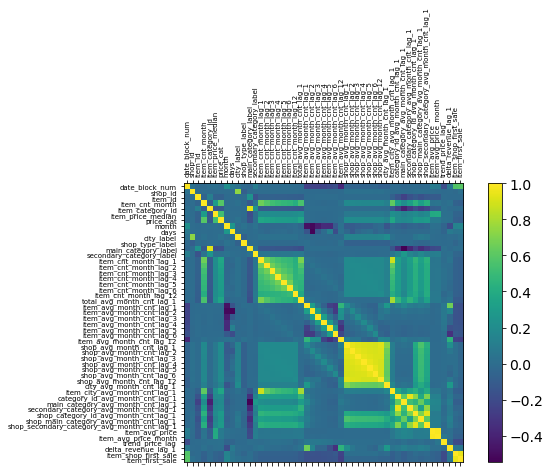

In [12]:
# Correlation matrix for monthly sales
all_pairs2 = all_pairs[all_pairs['date_block_num']<34]
#all_data2 = all_data2.drop(columns=['in_test', 'is_new_item'], inplace=True)

# Correlation matrix
f = plt.figure(figsize=(9, 5))
plt.matshow(all_pairs2.corr(), fignum=f.number)
plt.xticks(range(all_pairs2.shape[1]),all_pairs2.columns, fontsize=7, rotation=90)
plt.yticks(range(all_pairs2.shape[1]), all_pairs2.columns, fontsize=7)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Step 6. Data preparation and prediction (LGB)

This is our last step. We need to carefully prepare data, proceed with our splits and apply the LGB algorithm

In this section we will proceed with:
* **Drop first 11 months**. Since some of our lags cover the previous 12 months, the first 11 months have no complete lag information. Hence, to be coherent, we will drop this data (yep, that hurts)
* **Fill lag missings**. When needed.
* **Drop columns**. Some of them introduce data leaking (item_price_median), and others provide not enough information and generate noise in the algorithm (this is tested manually through the LGB)
* **Split data**. The filtering condition is just date_block_num. Train from 11 to 32, validation with 33 and test with 34.
* **Run LGB**. This might require some fine tuning and parameter optimization. Feel free to perform some grid search through cross-validation. 
* **Submit results**. Finally! Let's grab some coffe.

In [13]:
ts = time.time()
all_pairs = all_pairs[all_pairs.date_block_num > 11]
time.time() - ts

ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

all_pairs = fill_na(all_pairs)
all_pairs.fillna(0, inplace=True)    
time.time() - ts

3.092406988143921

In [14]:
all_pairs.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id', 'item_price_median', 'price_cat', 'month', 'days',
       'city_label', 'shop_type_label', 'main_category_label',
       'secondary_category_label', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'total_avg_month_cnt_lag_1', 'item_avg_month_cnt_lag_1',
       'item_avg_month_cnt_lag_2', 'item_avg_month_cnt_lag_3',
       'item_avg_month_cnt_lag_4', 'item_avg_month_cnt_lag_5',
       'item_avg_month_cnt_lag_6', 'item_avg_month_cnt_lag_12',
       'shop_avg_month_cnt_lag_1', 'shop_avg_month_cnt_lag_2',
       'shop_avg_month_cnt_lag_3', 'shop_avg_month_cnt_lag_4',
       'shop_avg_month_cnt_lag_5', 'shop_avg_month_cnt_lag_6',
       'shop_avg_month_cnt_lag_12', 'city_avg_month_cnt_lag_1',
       'item_city_avg_month_cnt_lag_1', 'category_id_avg_month_cnt_la

In [15]:
all_pairs.drop(['item_price_median', 'price_cat', 'item_avg_price', 'item_avg_price_month',
               'main_category_avg_month_cnt_lag_1','secondary_category_avg_month_cnt_lag_1',
               'shop_main_category_avg_month_cnt_lag_1','shop_secondary_category_avg_month_cnt_lag_1'], inplace=True, axis=1)

In [16]:
all_pairs.to_pickle('data.pkl')
data = pd.read_pickle('data.pkl')

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
gc.collect();

In [17]:
model=lgb.LGBMRegressor(
        n_estimators=10000,
        learning_rate=0.3,
        min_child_weight=300,
        #num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        #reg_alpha=0.04,
        #reg_lambda=0.073,
        #min_split_gain=0.0222415,
        verbose=1,
        seed=21)

model.fit(X_train, Y_train,eval_metric="rmse", eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=1, early_stopping_rounds = 10)

# Cross validation accuracy for 3 folds
#scores = cross_val_score(model, X_train, Y_train, cv=3)
#print(scores)

[1]	training's rmse: 1.0614	training's l2: 1.12656	valid_1's rmse: 1.0403	valid_1's l2: 1.08222
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 0.986521	training's l2: 0.973223	valid_1's rmse: 0.988171	valid_1's l2: 0.976481
[3]	training's rmse: 0.940615	training's l2: 0.884757	valid_1's rmse: 0.961519	valid_1's l2: 0.924518
[4]	training's rmse: 0.913122	training's l2: 0.833793	valid_1's rmse: 0.943689	valid_1's l2: 0.890549
[5]	training's rmse: 0.890889	training's l2: 0.793684	valid_1's rmse: 0.933565	valid_1's l2: 0.871544
[6]	training's rmse: 0.877895	training's l2: 0.7707	valid_1's rmse: 0.927947	valid_1's l2: 0.861087
[7]	training's rmse: 0.869019	training's l2: 0.755194	valid_1's rmse: 0.922705	valid_1's l2: 0.851385
[8]	training's rmse: 0.86353	training's l2: 0.745683	valid_1's rmse: 0.920638	valid_1's l2: 0.847574
[9]	training's rmse: 0.859265	training's l2: 0.738337	valid_1's rmse: 0.919679	valid_1's l2: 0.84581
[10]	training's rmse: 0.855912	

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.3, max_depth=8,
              min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=21,
              silent=True, subsample=0.8, subsample_for_bin=200000,
              subsample_freq=0, verbose=1)

In [18]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [19]:
submission

,ID,item_cnt_month
0,0,0.784935
1,1,0.745257
2,2,1.343971
3,3,0.645537
4,4,3.976066
...,...,...
214195,214195,0.112469
214196,214196,0.047944
214197,214197,0.051700
214198,214198,0.010597


In [20]:
"""

ALTERNATIVE OPTION WITH XGB. TIME CONSUMING, BUT ALLOWS TO STUDY FEATURE IMPORTANCE

ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=21)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

"""

'\n\nALTERNATIVE OPTION WITH XGB. TIME CONSUMING, BUT ALLOWS TO STUDY FEATURE IMPORTANCE\n\nts = time.time()\n\nmodel = XGBRegressor(\n    max_depth=8,\n    n_estimators=1000,\n    min_child_weight=300, \n    colsample_bytree=0.8, \n    subsample=0.8, \n    eta=0.3,    \n    seed=21)\n\nmodel.fit(\n    X_train, \n    Y_train, \n    eval_metric="rmse", \n    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], \n    verbose=True, \n    early_stopping_rounds = 10)\n\ntime.time() - ts\n\n\ndef plot_features(booster, figsize):    \n    fig, ax = plt.subplots(1,1,figsize=figsize)\n    return plot_importance(booster=booster, ax=ax)\n\nplot_features(model, (10,14))\n\n'